In [1]:
import numpy as np
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta, Naive, SeasonalNaive
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse, rmse, smape

from utils import plot_metric_bar_multi, evaluate_cv, get_best_model_forecast

## 1) Load Data

In [2]:
# Load in M4 dataset
Y_train_df = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
Y_test_df = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv')
Y_train_df['ds'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(Y_train_df['ds'], unit='h')
Y_test_df['ds'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(Y_test_df['ds'], unit='h')

In [3]:
# randomly select 8 series
n_series = 8
uids = Y_train_df['unique_id'].drop_duplicates().sample(8, random_state=23).values
df_train = Y_train_df.query('unique_id in @uids')
df_test = Y_test_df.query('unique_id in @uids')

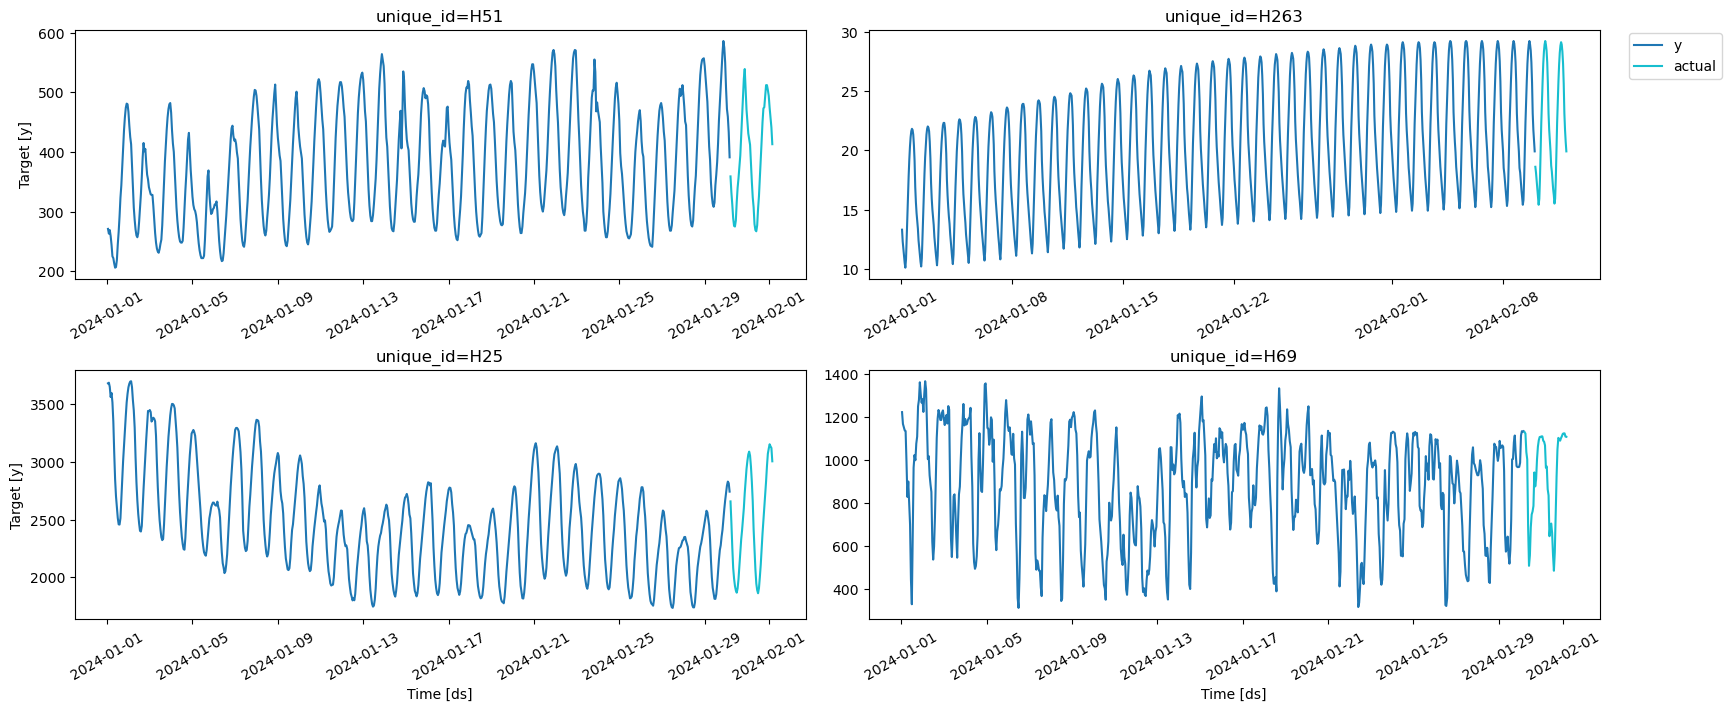

In [4]:
plot_series(df_train, df_test.rename(columns={"y": "actual"}), max_ids = 4)

## 2) Baseline: Naive & SeasonalNaive
Before diving into more sophisticated models, we begin with two classical and interpretable statistical baselines:

**Naive model**: always predicts the last observed value.

**SeasonalNaive model**: predicts that each point will repeat the value observed one season ago (e.g.,the same hour yesterday for hourly data).

In [5]:
# Use Naive and SeasonalNaive model as a baseline
sf_base = StatsForecast(
    models=[Naive(), SeasonalNaive(season_length=24)], 
    freq='H', 
    n_jobs=-1
    )

# Make baseline prediction 
fcst_base = sf_base.forecast(df = df_train, h = 48)

# Evaluate with test dataset
eval_base = df_test.merge(fcst_base, on = ['unique_id', 'ds'])

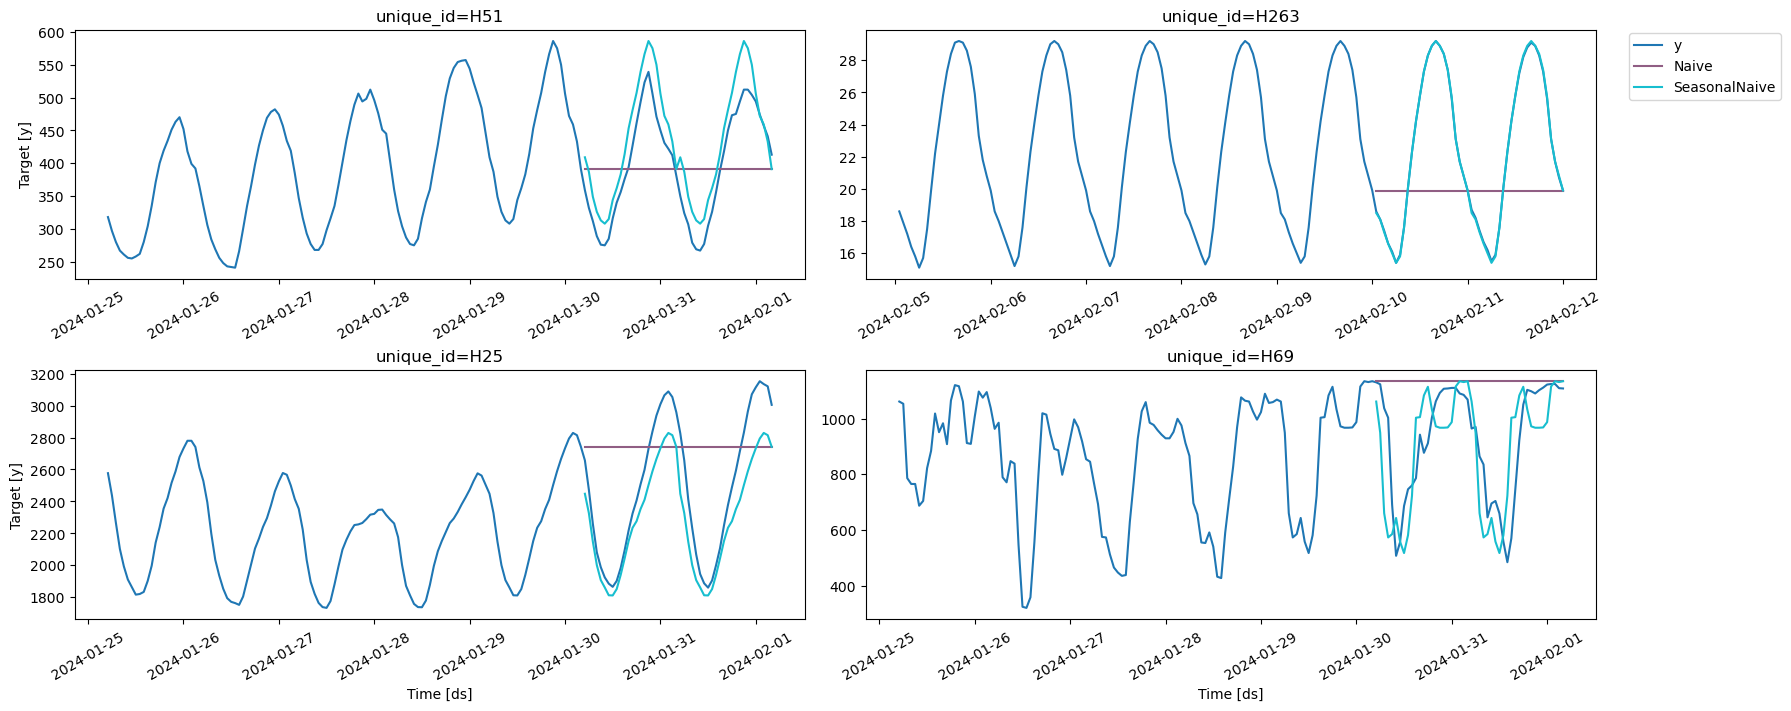

In [6]:
# Plotting the baseline result
plot_series(df_train, eval_base, max_ids = 4, max_insample_length= 5*24)

In [7]:
# Evaluate performance 
metrics_base = evaluate(
    df=eval_base,
    metrics=[mae, rmse, smape],
    agg_fn='mean',
).set_index('metric')
metrics_base

,Naive,SeasonalNaive
metric,,
mae,142.755729,53.627083
rmse,179.520049,66.529088
smape,0.252074,0.065754


## 3) StatsForecast Models
After establishing the baselines, we now move on to a set of classical statistical forecasting models implemented efficiently in StatsForecast. These models automatically estimate optimal parameters for each series.

**AutoARIMA**: Captures autocorrelation patterns and adjusts for both trend and seasonality through differencing and autoregressive components.

**AutoETS**: Exponential smoothing model that automatically selects additive or multiplicative trend/seasonal components. Excellent for smooth, structured data.

**AutoCES**: Complex Exponential Smoothing, which extends ETS by modeling cyclical components in a more flexible way.

**AutoTheta**: A robust, fast method derived from the Theta forecasting model


In [8]:
# Define models
models = [
    AutoARIMA(season_length=24),      # With seasonality set as 24 for hourly data
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    AutoTheta(season_length=24)
]

In [9]:
# Initialize statsforecast 
sf = StatsForecast(
    models=models, 
    freq='H', 
    n_jobs=-1
    )

# Autofit the stats models and make prediction all in one step.
fcst_sf_models = sf.forecast(df = df_train, h = 48, level=[90])

# Evaluate with test dataset
eval_sf_models = df_test.merge(fcst_sf_models, on = ['unique_id', 'ds'])

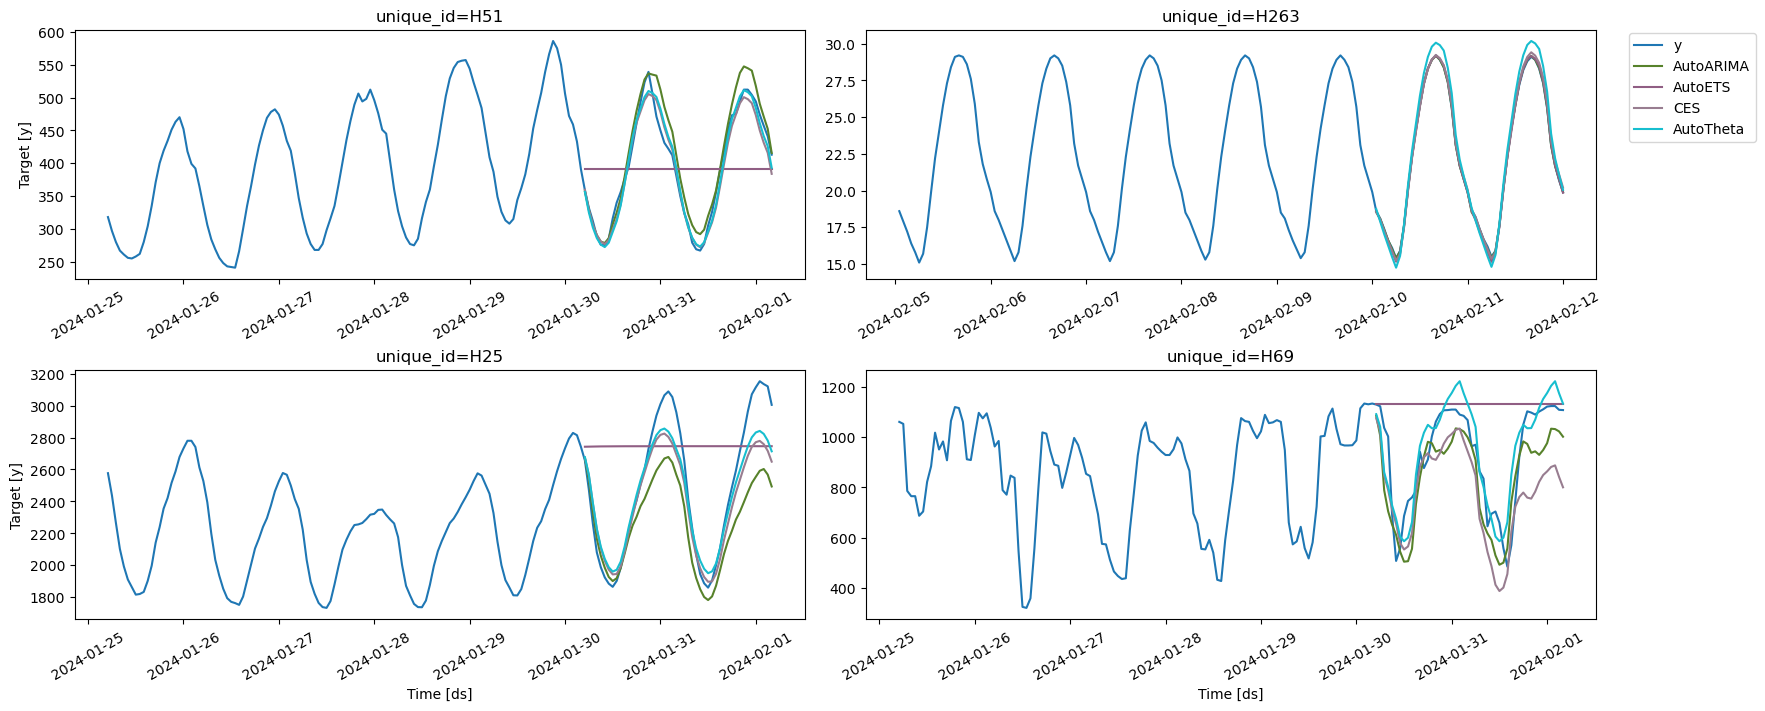

In [10]:
# Plot the result
plot_series(df_train, eval_sf_models, max_ids = 4, max_insample_length= 5*24)

In [11]:
# Evaluation Metrics
metrics_sf_models = evaluate(
    df= eval_sf_models,
    metrics=[mae, rmse, smape],
    agg_fn='mean',
).set_index('metric')
metrics_sf_models

,AutoARIMA,AutoETS,CES,AutoTheta
metric,,,,
mae,57.180205,98.516010,49.118898,49.856542
rmse,71.456734,122.784231,60.979897,65.105242
smape,0.063307,0.075775,0.079244,0.076261


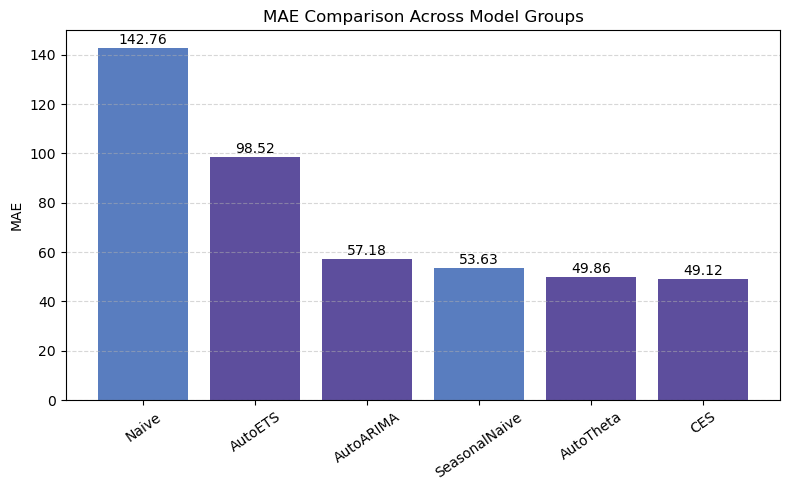

In [12]:
plot_metric_bar_multi(dfs = [metrics_sf_models, metrics_base])

### 4) Cross-Validation with a Rolling Window
In this section, we use rolling-origin cross-validation to select the best model for each time series. Nixtla’s implementation of cross-validation ensures the temporal order is respected, avoiding data leakage and producing a more stable and streamlined evaluation process.

**How it works:**  
1. Start with an initial training window and forecast the next *h* steps.  
2. Slide the window forward by *step_size* and repeat.  
3. Compute error metrics for each window and model.  
4. Select the model with the **lowest average error** for each series.

![Rolling-window cross-validation](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

In [13]:
# Run cross-validation with 2 rolling windows of 24 steps each
cv_df = sf.cross_validation(
    df=df_train,
    h=24,          # forecast horizon
    step_size=24,  # roll the window forward by 24 steps each time
    n_windows=2    # number of evaluation windows
)

In [14]:
# Evaluate model performance using MSE across cross-validation windows
evaluation_df = evaluate_cv(cv_df, mae)

# Count how many times each model was selected as best
evaluation_df['best_statsforecast_model'].value_counts().to_frame().reset_index()

,best_statsforecast_model,count
0,AutoARIMA,3
1,AutoETS,2
2,AutoTheta,2
3,CES,1


After selecting the best model for each series, we visualize the final forecasts alongside the actual test data.

Here, the 90% **conformal prediction interval** (shown as the shaded band) provides an estimate of forecast uncertainty
reflecting how much variation we can expect in future observations based on past residuals.

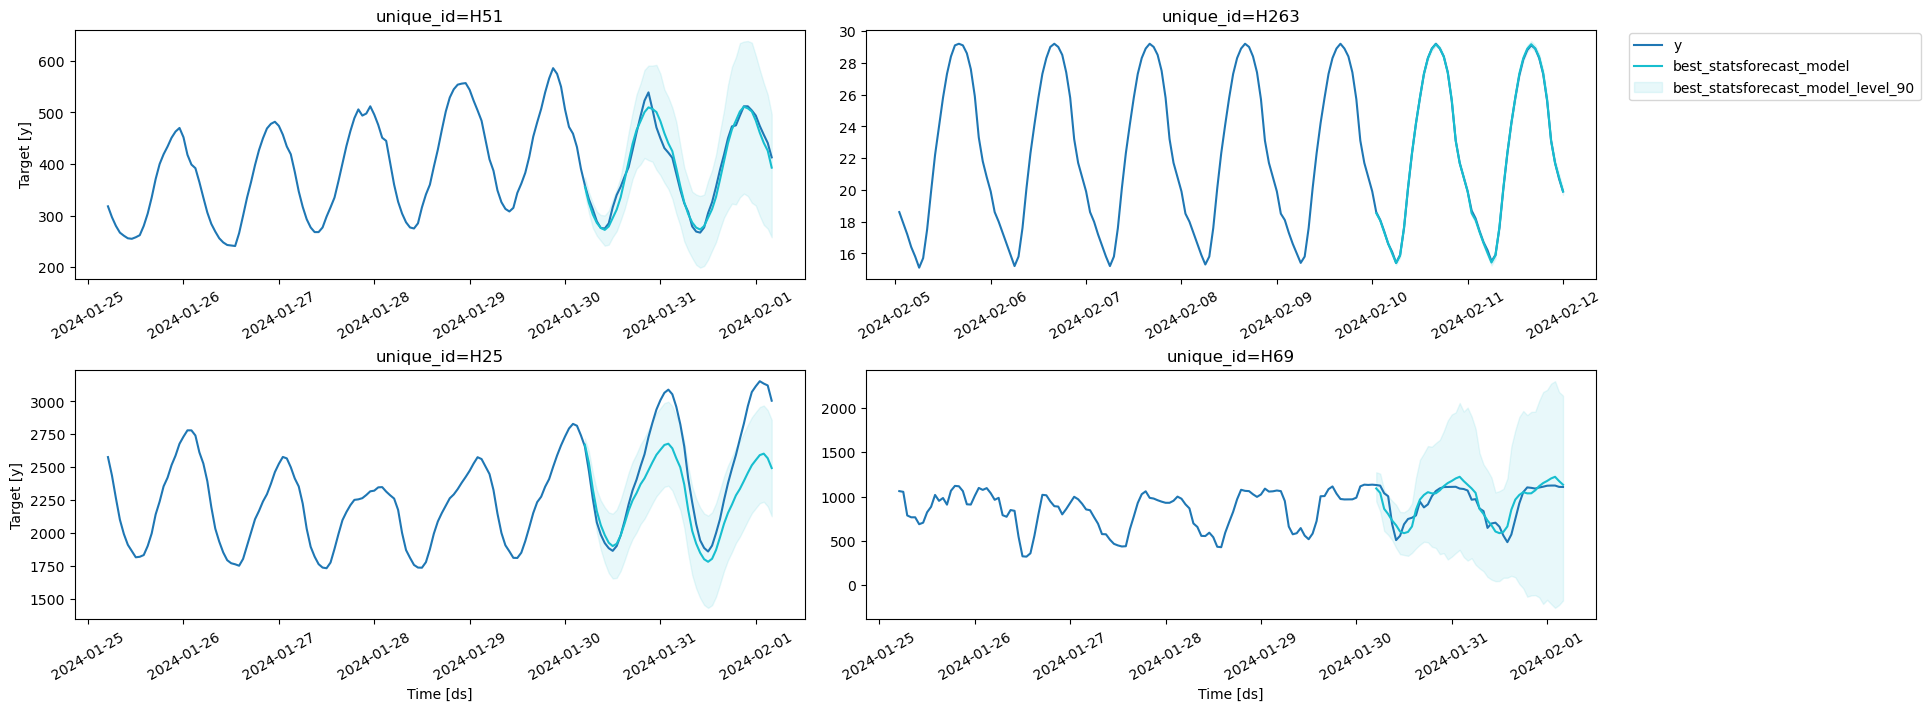

In [15]:
# Extract the forecasts from the best-performing model for each series
best_fcst_sf = get_best_model_forecast(fcst_sf_models, evaluation_df)
eval_best_sf = df_test.merge(best_fcst_sf, on = ['unique_id', 'ds'])

# Plot forecasts with 90% conformal prediction interval
plot_series(df_train, eval_best_sf, level=[90], max_insample_length = 5*24, max_ids = 4)

In [16]:
metrics_sf_best = evaluate(
    df=eval_best_sf,
    metrics=[mae, mse, rmse, smape],
    agg_fn='mean',
).set_index('metric')
metrics_sf_best

,best_statsforecast_model
metric,
mae,52.153005
mse,13227.573832
rmse,66.165369
smape,0.057053


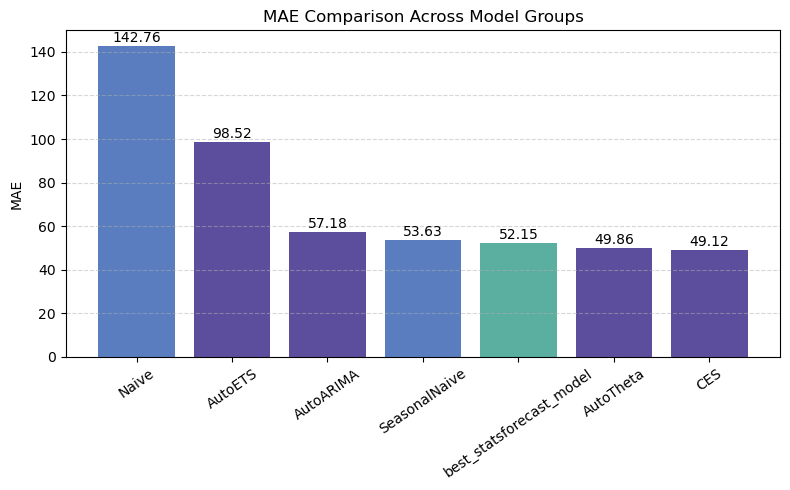

In [17]:
plot_metric_bar_multi(dfs = [metrics_sf_models, metrics_base, metrics_sf_best])

## 5) Make Forecast with TimeGPT
Produce fast, accurate forecasts using TimeGPT, then compare against our statistical baselines and StatsForecast models.

**Why TimeGPT?**

- Strong out-of-the-box accuracy with minimal tuning

- Handles trend/seasonality/holidays automatically

- Scales to many series with simple APIs

### 5 a) Forecast with TimeGPT-1

In [18]:
# Import necessary packages
import os
from dotenv import load_dotenv
from nixtla import NixtlaClient

# Load environment variables from .env
load_dotenv()
api_key = os.getenv("NIXTLA_API_KEY")
base_url = os.getenv('base_url')

In [19]:
print("API key loaded:", api_key)

API key loaded: nixak-SZ0pbmiTmAwf0JgqXJsJnUFqu90bQpWrRiym35C0OLgaSJSRaS7w2fDlp8CGAwQOUdVfPlgyijU4RENP


In [20]:
# Initialize the client
nixtla_client = NixtlaClient(api_key=api_key)

In [21]:
# Simple zero-shot TimeGPT forecast
fcst_timegpt = nixtla_client.forecast(
    df=df_train,
    h=48,         # forecast horizon (next 48 hours)
    freq='H',     # hourly frequency
    level = ['80', '90']
)
# fcst_timegpt.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [22]:
# Add finetune steps to make it more accurate
fcst_timegpt_ft = nixtla_client.forecast(
    df=df_train,
    h=48,
    freq='H',
    level = ['80', '90'],
    finetune_steps = 30     #Here we use 100 finetune steps. Choose the value base on your usecase
)
# fcst_timegpt.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


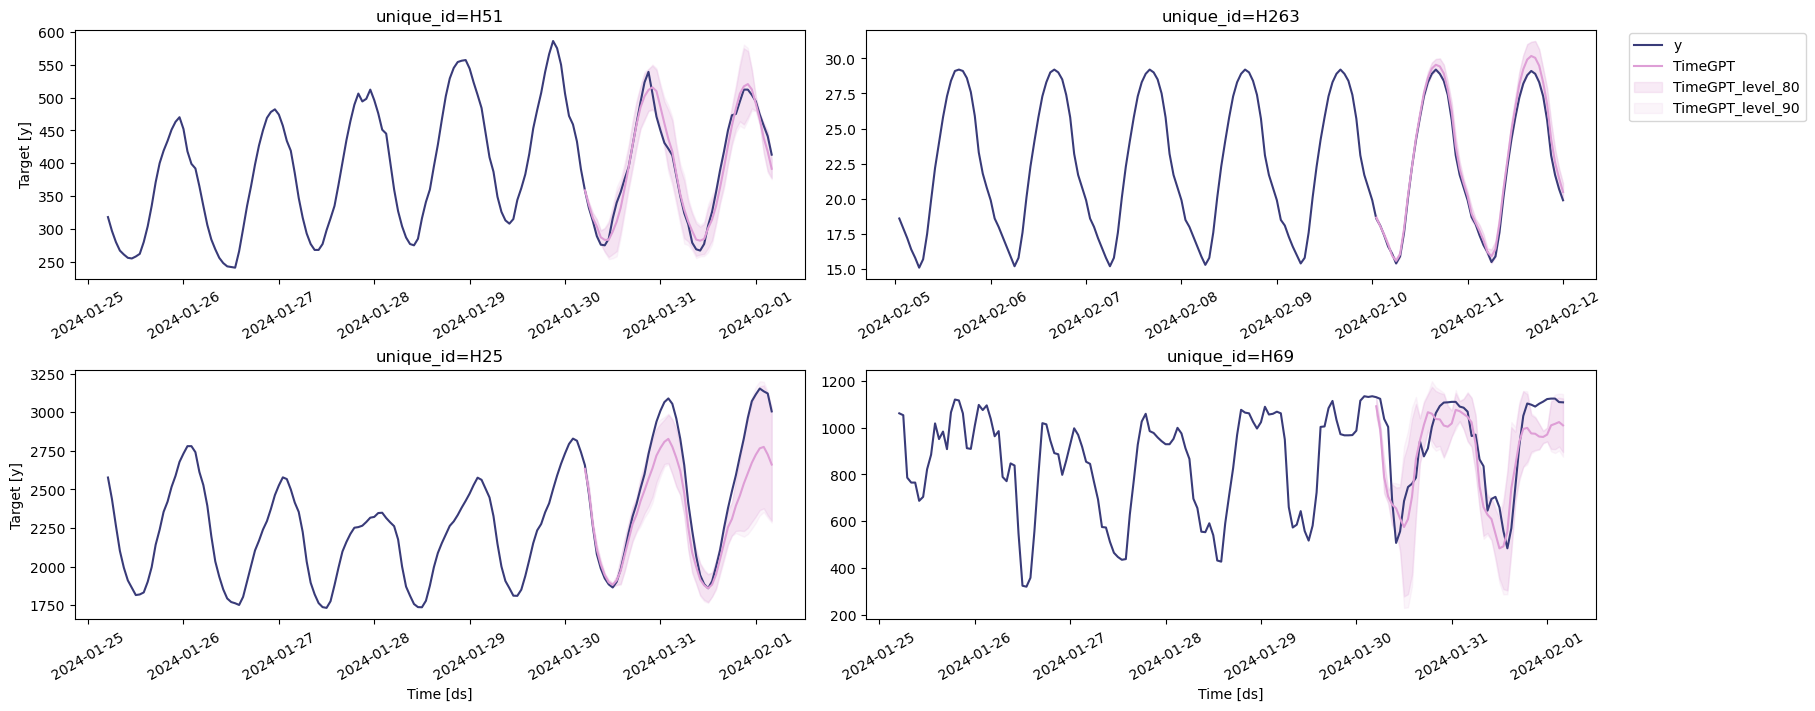

In [23]:
eval_tgpt_ft = df_test.merge(fcst_timegpt_ft, on = ['unique_id', 'ds'])
nixtla_client.plot(df_train, eval_tgpt_ft, level = ['80', '90'], max_insample_length=5 * 24, max_ids=4)

In [24]:
eval_df_tgpt = evaluate(
    df= df_test
        .merge(fcst_timegpt.rename(columns={'TimeGPT': 'TimeGPT_zero_shot'}), on=['unique_id', 'ds'])
        .merge(fcst_timegpt_ft.rename(columns={'TimeGPT': 'TimeGPT_finetune'}), on=['unique_id', 'ds']),
    time_col = 'ds',
    metrics=[mae, rmse, smape],
    agg_fn='mean',
).set_index('metric')
eval_df_tgpt

,TimeGPT_zero_shot,TimeGPT_finetune
metric,,
mae,41.263690,39.982127
rmse,53.229181,51.370958
smape,0.056424,0.064989


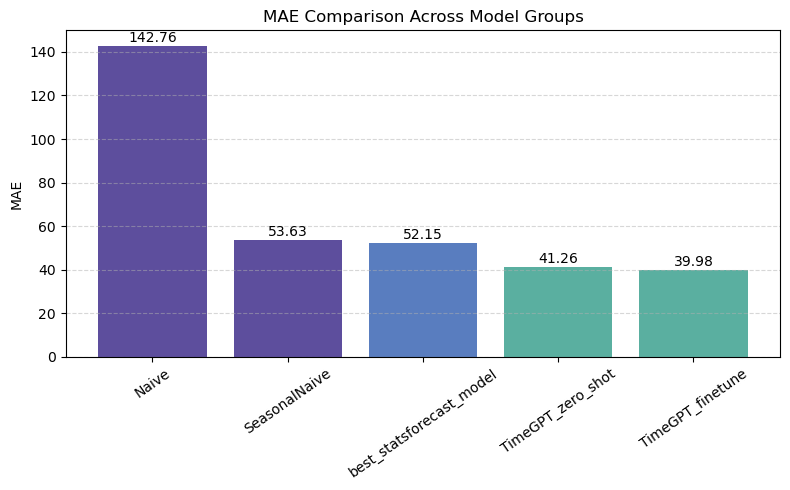

In [25]:
plot_metric_bar_multi(dfs = [metrics_base, metrics_sf_best, eval_df_tgpt])

### 5 b) Forecast with the newly launched TimeGPT-2

In [26]:
# Initialize nixtla_clienct with TimeGPT-2 credentials
nixtla_client = NixtlaClient(api_key=api_key, base_url = base_url)

In [27]:
fcst_timegpt_2 = nixtla_client.forecast(
    df=df_train,
    h=48,
    freq='H',
    level = ['80', '90'],
    model = 'timegpt-2'
)
eval_tgpt_2 = df_test.merge(fcst_timegpt_2, on = ['unique_id', 'ds'])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [28]:
metrics_tgpt_2 = evaluate(
    df=df_test.merge(fcst_timegpt_2.rename(columns={'TimeGPT': 'TimeGPT_2'}), on = ['unique_id', 'ds']),
    metrics=[mae, mse, rmse, smape],
    agg_fn='mean',
).set_index('metric')
metrics_tgpt_2

,TimeGPT_2
metric,
mae,21.117466
mse,1591.388344
rmse,27.029288
smape,0.035599


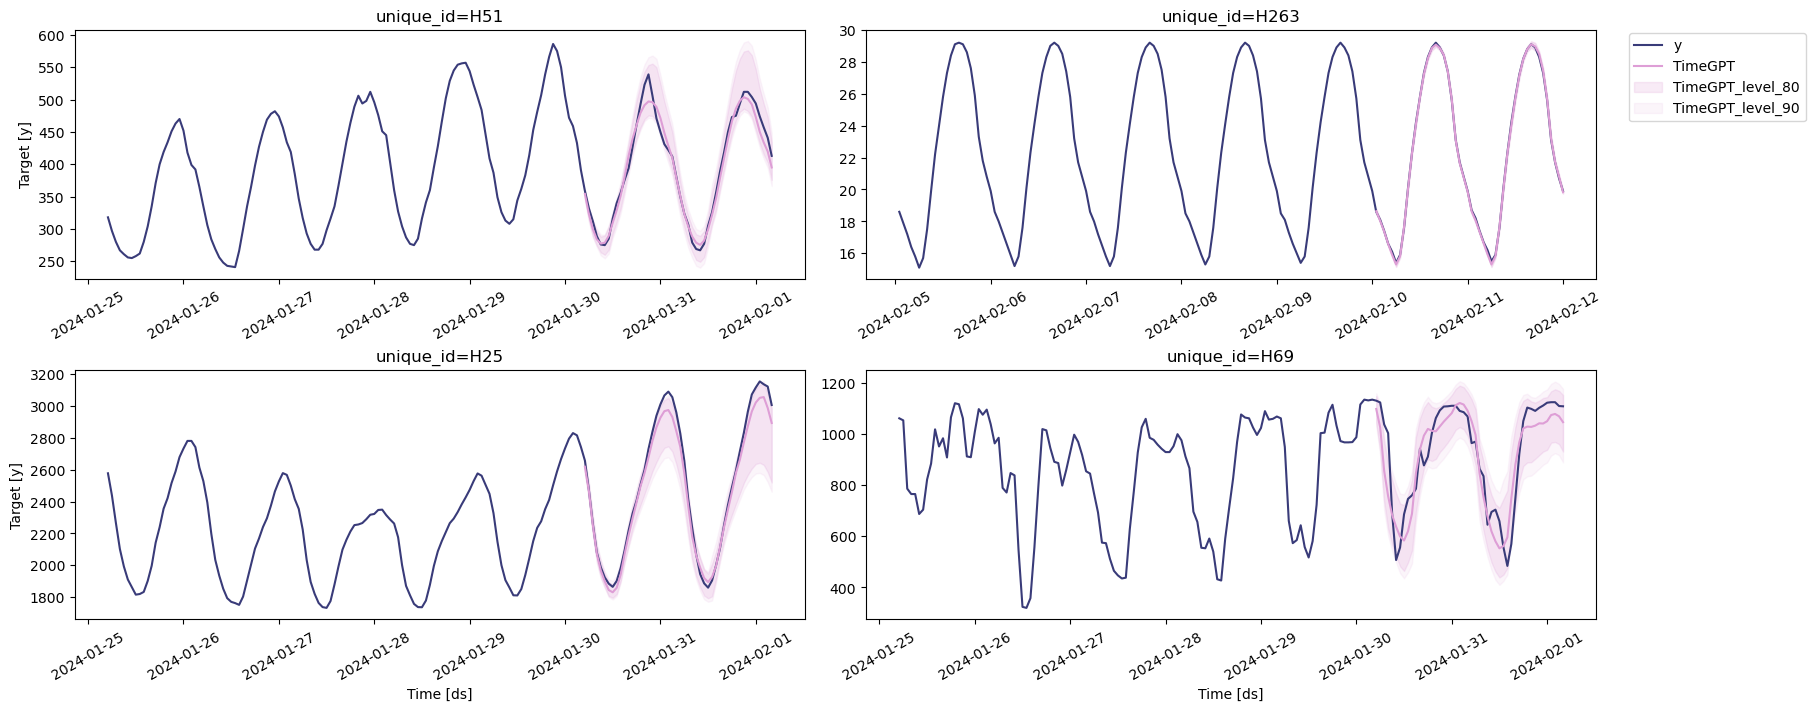

In [29]:
nixtla_client.plot(df_train, eval_tgpt_2, level = ['80', '90'], max_insample_length=5 * 24, max_ids=4)

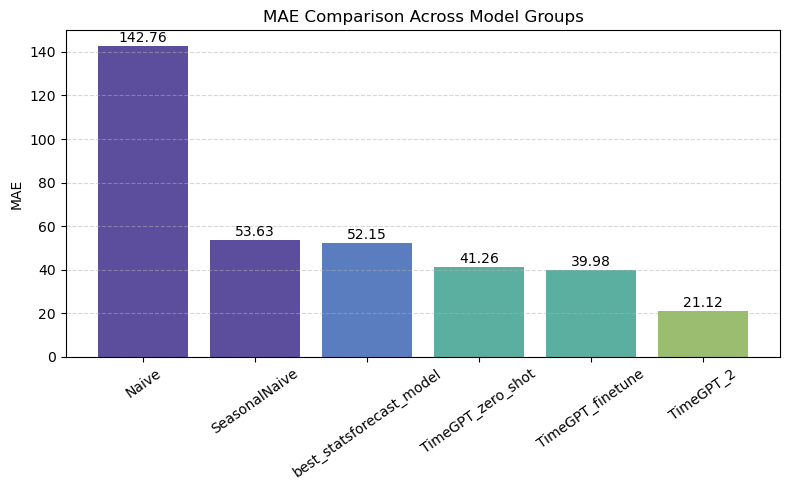

In [30]:
plot_metric_bar_multi(dfs = [metrics_base, metrics_sf_best, eval_df_tgpt, metrics_tgpt_2])